[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [2]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [ ]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Prediction for Jane Dow (Loan Eligibility): Denied


In [6]:
X.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,2,1,7,4,6,3,2,1,0,0,40,38
1,38,2,11,9,2,4,0,4,1,0,0,50,38
2,28,1,7,12,2,10,0,4,1,0,0,40,38
3,44,2,15,10,2,6,0,2,1,7688,0,40,38
5,34,2,0,6,4,7,1,4,1,0,0,30,38


In [7]:
jane_df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,37,2,9,13,4,3,1,4,0,0,0,50,38


### TREE SHAP

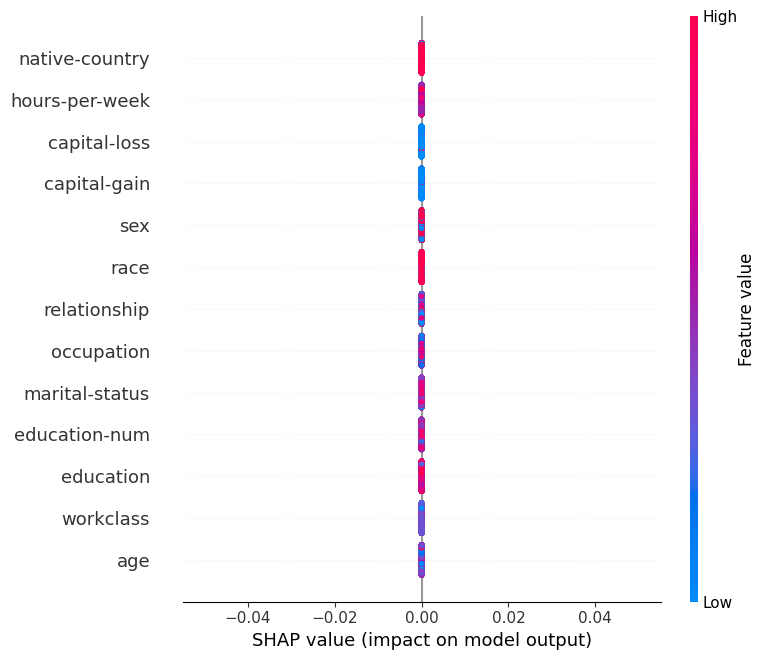

In [13]:
import shap
# Create TreeExplainer
explainer = shap.TreeExplainer(model_adult)

# Explain predictions for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary (feature importance across dataset)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

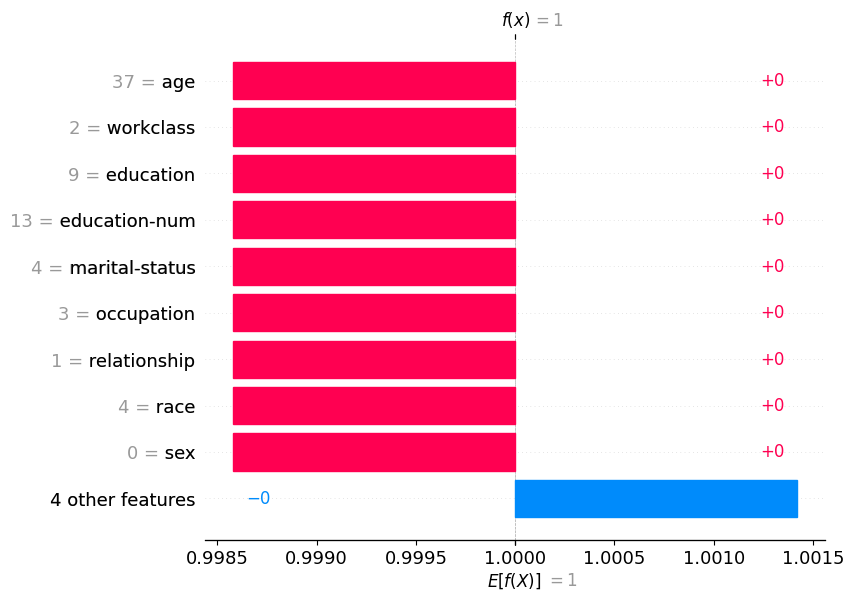

In [27]:
# Jane instance explanation
shap_jane = explainer.shap_values(jane_df)
shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],                         # first row
        base_values=explainer.expected_value,
        data=jane_df.iloc[0],
        feature_names=jane_df.columns.tolist()
    ))


### ICE

c:\Users\thete\Github\ML-Court\newv\lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


AttributeError: RandomForestClassifier has none of the following attributes: decision_function.

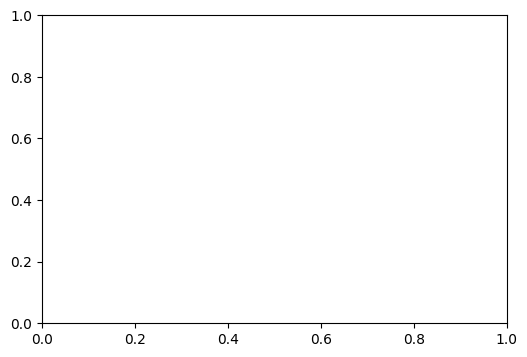

In [36]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
display = PartialDependenceDisplay.from_estimator(
    model_adult,
    X_test,
    [0],
    kind="individual",
    response_method="decision_function",  # instead of predict_proba
    ax=ax
)

### LIME

In [42]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=["label"],  # your single label
    mode="classification"
)

exp = explainer.explain_instance(
    jane_df.values[0],
    model_adult.predict_proba,
    num_features=len(X_train.columns)
)

exp.show_in_notebook(show_table=True)

c:\Users\thete\Github\ML-Court\newv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

In [41]:
print((y_train == 0).sum())
print((y_test == 0).sum())
print((y_train == 1).sum())
print((y_test == 1).sum())

36177
9045
0
0


### Interpretation
Explainability methods are providing weak results. SHAP is implying she is very much in line with the others who were rejected, but also notes there is not particular feature that determines who is rejected. Other methods failed to assess the model. On further analysis, the model is trained only on those who make less than $50k.

## Prosecution

After running explainability methods on this model design, I have come to the conclusion Jane was unfairly denied. The model is only trained on those with less than $50,000 in income, hence the model is unable to learn proper bounds for those who make more. She is assessed as someone who makes less than $50,000, but in reality the model has no idea what someone who makes more looks like. 